# 1. Weisfeiler Lehman:
### 1.1. Initialize graphs as the following image:
![image info](./data/graph_1.png)
### 1.2. Compute WL to compare 2 above graphs WITHOUT labels
### 1.3. Compute WL to compare 2 above graphs WITH node labels
### 1.4. Compute WL to compare 2 above graphs WITH edge labels
### 1.5. Compute 3-WL to compare 2 above graphs WITHOUT labels

In [2]:
# !pip install networkx pandas numpy matplotlib grakel

import networkx as nx
import numpy as np
from networkx.algorithms import isomorphism
import matplotlib.pyplot as plt
import copy
import pprint
import itertools
import hashlib
import joblib
from collections import Counter
from grakel.utils import graph_from_networkx
from grakel import GraphKernel

In [10]:
# 1.1 Initialize graphs as the following image

G1 = nx.Graph()
G1.add_edges_from(
    [
        (1, 2, {"label": "Friendship"}),
        (1, 3, {"label": "Friendship"}),
        (1, 4, {"label": "Friendship"}),
        (3, 4, {"label": "Friendship"}),
    ]
)
G1_node_attributes = {
    1: "Thomas",
    2: "Dolores",
    3: "Jose",
    4: "Jack",
}
# Set node labels by using node attributes
nx.set_node_attributes(G1, G1_node_attributes, name="label")

G2 = nx.Graph()
G2.add_edges_from(
    [
        (5, 6, {"label": "Friendship"}),
        (5, 8, {"label": "Friendship"}),
        (5, 7, {"label": "Friendship"}),
        (6, 8, {"label": "Friendship"}),
    ]
)
G2_node_attributes = {
    5: "Ming",
    6: "Amy",
    7: "Wyatt",
    8: "Emily",
}

# Set node labels by using node attributes
nx.set_node_attributes(G2, G2_node_attributes, name="label")

{1: 'Thomas', 2: 'Dolores', 3: 'Jose', 4: 'Jack'}


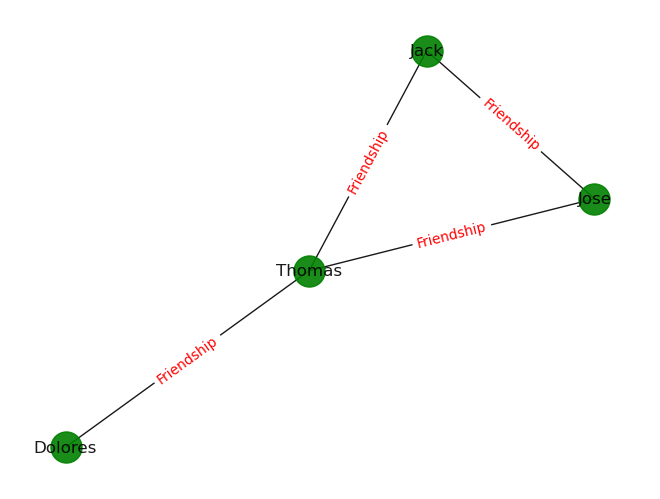

In [11]:
def draw_graph_with_labels(G, label='label'):
    labels = dict()
    names = nx.get_node_attributes(G, label)
    print(names)
    for node in G.nodes:
        labels[node] = f"{names[node]}"
    pos = nx.spring_layout(G)
    plt.figure()
    nx.draw(
        G, pos, edge_color='black', width=1, linewidths=1,
        node_size=500, node_color='green', alpha=0.9,
        labels=labels
    )
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=nx.get_edge_attributes(G, "label"),
        font_color='red'
    )
    plt.axis('off')
    plt.show()
    
draw_graph_with_labels(G1)

{5: 'Ming', 6: 'Amy', 8: 'Emily', 7: 'Wyatt'}


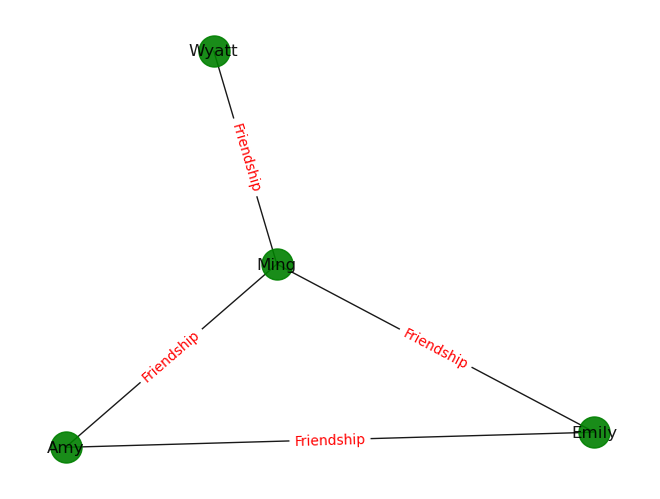

In [12]:
draw_graph_with_labels(G2)

In [13]:
# 1.2. Compute WL to compare 2 above graphs without labels.
g1_hash = nx.weisfeiler_lehman_graph_hash(G1)
g2_hash = nx.weisfeiler_lehman_graph_hash(G2)

# g1_hash and g2_hash are equal when they are isomorphic
print(f"First  graph hash: {g1_hash}")
print(f"Second graph hash: {g2_hash}")
print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

First  graph hash: 7bc4dde9a09d0b94c5097b219891d81a
Second graph hash: 7bc4dde9a09d0b94c5097b219891d81a
Checking graph isomorphic: True


In [14]:
# 1.3. Compute WL to compare 2 above graphs with node labels.
g1_hash = nx.weisfeiler_lehman_graph_hash(G1, node_attr="label")
g2_hash = nx.weisfeiler_lehman_graph_hash(G2, node_attr="label")

# g1_hash and g2_hash are equal when they are isomorphic
print(f"First  graph hash: {g1_hash}")
print(f"Second graph hash: {g2_hash}")
print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

First  graph hash: 892373472f0ae7378ef7283f2904a750
Second graph hash: 22dbf2634b618d4b100ee18a1cbbb40f
Checking graph isomorphic: False


In [15]:
# 1.4. Compute WL to compare 2 above graphs with edge labels.
g1_hash = nx.weisfeiler_lehman_graph_hash(G1, edge_attr="label")
g2_hash = nx.weisfeiler_lehman_graph_hash(G2, edge_attr="label")

# g1_hash and g2_hash are equal when they are isomorphic
print(f"First  graph hash: {g1_hash}")
print(f"Second graph hash: {g2_hash}")
print(f"Checking graph isomorphic: {g1_hash==g2_hash}")



First  graph hash: 92efe26c38838089f23c1bb529264194
Second graph hash: 92efe26c38838089f23c1bb529264194
Checking graph isomorphic: True


In [8]:
# 1.5. Compute 3-WL to compare 2 above graphs without labels.

# A base function to calculate WL
def compute_base_WL(graph, k, verbose, n_set, initial_colors_func, find_neighbors_func):    
    G, n = n_set(graph)
    colors = initial_colors_func(n)
    old_colors = copy.deepcopy(colors)
    
    for i in range(len(n)):
        for node in n:
            neigh_colors = "".join([colors[i][0] for i in find_neighbors_func(G, n, node)])
            colors[node].extend([neigh_colors])
            colors[node].sort()
            
        # Update with the hash
        colors = {i: [hashlib.sha224("".join(colors[i]).encode('utf-8')).hexdigest()] for i in colors}
        
        if list(Counter([item for sublist in colors.values() for item in sublist]).values()) == list(Counter([item for sublist in old_colors.values() for item in sublist]).values()) and i != 0:
            if verbose:
                print(f'Converged at iteration {i}!')
            break
        
        old_colors = copy.deepcopy(colors)
    canonical_form = sorted(Counter([item for sublist in colors.values() for item in sublist]).items())
    
    if verbose:
        print(f'Canonical Form Found: \n {canonical_form} \n')
        
    return canonical_form

def kWL(G, k, verbose=False):
    def n_set(G):
        G = nx.convert_node_labels_to_integers(G)
        V = list(G.nodes())
        
        # Considering node with k-tuples of nodes
        V_k = [comb for comb in itertools.combinations(V, k)]
        return G, V_k

    def set_initial_colors(n):
        return {i: [hashlib.sha224(str(i).encode('utf-8')).hexdigest()] for i in n}

    # Find k-hop neighbors
    def find_neighbors(G, V_k, node):
        return [n for n in V_k if len(set(n) - set(V_k[V_k.index(node)])) == 1]

    return compute_base_WL(G, k, verbose, n_set, set_initial_colors, find_neighbors)

# Run with k=3
k=3
g1_hash = kWL(G1, k)
g2_hash = kWL(G2, k)

print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

Checking graph isomorphic: True


# 2. Other methods:
### 2.1. Create graphs as the following image:
![image info](./data/graph_2.png)
### 2.2. Using shortest path kernel to compare 2 above graphs
### 2.3. Using pyramid match graph kernel to compare 2 above graphs
### 2.4. Using Random Walk Kernel to compare 2 above graphs
### 2.5. Using Graphlet Kernel to compare 2 above graphs

In [16]:
G1 = nx.Graph()
G1.add_edges_from(
    [
        (1, 2),
        (1, 3),
        (1, 4),
        (2, 3),
        (3, 5),
        (4, 5)
    ]
)
nx.set_node_attributes(G1, {1:'orange', 2:'yellow', 3:'green', 4: 'blue', 5: 'teal'}, 'color')

G2 = nx.Graph()

G2.add_edges_from(
    [
        (3, 1),
        (3, 2),
        (3, 5),
        (1, 2),
        (1, 4),
        (4, 5)
    ]
)
nx.set_node_attributes(G2, {1:'orange', 2:'yellow', 3:'green', 4: 'blue', 5: 'teal'}, 'color')

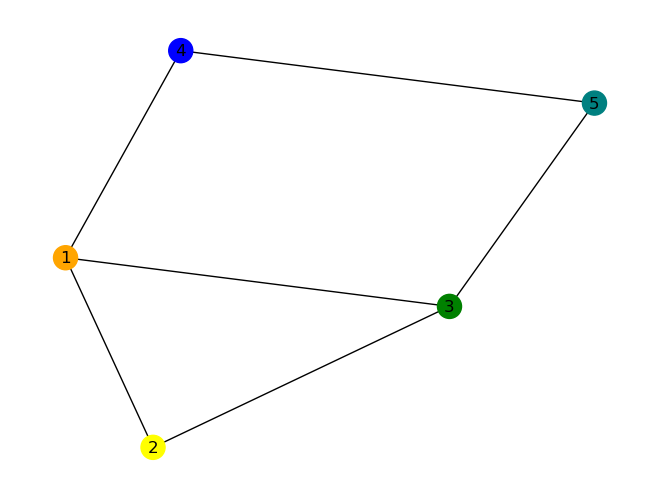

In [17]:
def draw_graph_colors(G):
    colors = nx.get_node_attributes(G, "color") 
    color_map = []
    for node in G.nodes:
        color_map.append(f"{colors[node]}")
    nx.draw(G, node_color=color_map, with_labels=True)
    plt.show()

draw_graph_colors(G1)

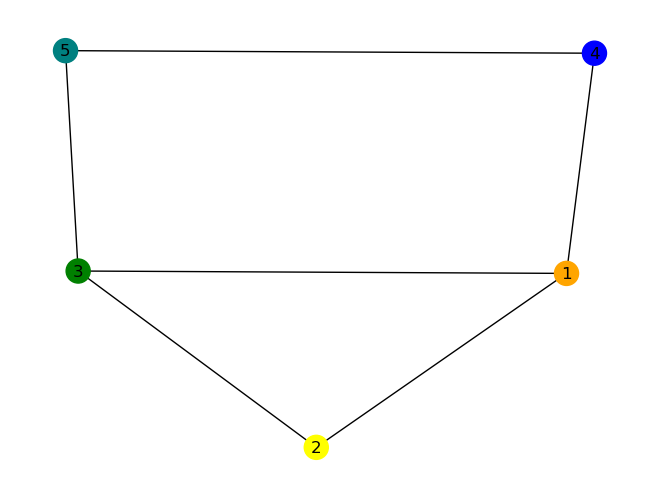

In [18]:
draw_graph_colors(G2)

In [20]:
# 2.2 Using shortest path kernel to compare 2 above graphs
nx_graphs = [G1, G2]

graphs = graph_from_networkx(nx_graphs, node_labels_tag='color')

gk = GraphKernel(kernel=[{"name": "shortest_path"}], normalize=True)
K = gk.fit_transform(graphs)

print(K)

[[1. 1.]
 [1. 1.]]


In [25]:
# 2.3. Using pyramid match graph kernel to compare 2 above graphs.
from grakel.kernels import PyramidMatch
graphs = graph_from_networkx(nx_graphs, node_labels_tag='color')

pmk = PyramidMatch(normalize=True)
K = pmk.fit_transform(graphs)

print("Pyramid Match Kernel matrix:")
print(K)

Pyramid Match Kernel matrix:
[[1. 1.]
 [1. 1.]]


In [27]:
# 2.4. Using Random Walk Kernel to compare 2 above graphs
import networkx as nx
import random

def random_walk_kernel(graph, walk_length=2):
    # Initialize the kernel to zero
    kernel = 0

    # Get a list of nodes
    nodes = list(graph.nodes)

    # Perform a random walk for each node in the graph
    for node in nodes:
        # Start the walk at the current node
        walk = [node]

        # Continue the walk
        for i in range(walk_length):
            # Get the neighbors of the current node
            neighbors = list(nx.all_neighbors(graph, walk[-1]))

            # If the current node has no neighbors, end the walk
            if not neighbors:
                break

            # Choose a neighbor at random
            next_node = random.choice(neighbors)

            # Add the chosen neighbor to the walk
            walk.append(next_node)

        # Update the kernel
        kernel += len(walk) - 1

    return kernel

G = nx.compose(G1, G2)
kernel_value = random_walk_kernel(G, walk_length=2)

print(f"The random walk kernel value is: {kernel_value}")


The random walk kernel value is: 10


In [26]:
# 2.5. Using Graphlet Kernel to compare 2 above graphs
import networkx as nx
import numpy as np
from itertools import combinations

def compute_graphlet_counts(G, k):
    """
    Compute the counts of k-node graphlets in the given graph.

    Parameters:
        G (networkx.Graph): The input graph.
        k (int): The size of the graphlets to count.

    Returns:
        dict: A dictionary containing the counts of k-node graphlets.
    """
    graphlet_counts = {graphlet: 0 for graphlet in range(1, k+1)}

    for node in G.nodes():
    # Generate the induced subgraph with node and its neighbors
        subgraph_nodes = [node] + list(G.neighbors(node))
        subgraph = G.subgraph(subgraph_nodes)

        # Count the occurrences of k-node graphlets in the subgraph
        for graphlet_size in range(1, k+1):
            for subgraph_nodes_subset in combinations(subgraph_nodes, graphlet_size):
                if G.subgraph(subgraph_nodes_subset).number_of_nodes() == graphlet_size:
                    graphlet_counts[graphlet_size] += 1

    return graphlet_counts

def compute_graphlet_kernel(G1, G2, k):
    """
    Compute the graphlet kernel between two graphs.

    Parameters:
        G1 (networkx.Graph): The first input graph.
        G2 (networkx.Graph): The second input graph.
        k (int): The size of the graphlets to count.

    Returns:
        float: The similarity score between the two graphs.
    """
    # Compute the counts of k-node graphlets in each graph
    graphlet_counts_G1 = compute_graphlet_counts(G1, k)
    graphlet_counts_G2 = compute_graphlet_counts(G2, k)

    # Compute the kernel value by comparing the counts of graphlets
    kernel_value = 0
    for graphlet in range(1, k+1):
        kernel_value += min(graphlet_counts_G1[graphlet], graphlet_counts_G2[graphlet])

    return kernel_value

k = 3  # Size of the graphlets to count

kernel_value = compute_graphlet_kernel(G1, G2, k)
print("Graphlet kernel value:", kernel_value)


Graphlet kernel value: 49
